<a href="https://colab.research.google.com/github/Rouic/classification-experiment-ml/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from datasets import Dataset as HFDataset

class TreeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TreeClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)  # Adjust input size if using different embeddings

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        logits = self.fc(pooled_output)
        return logits

In [ ]:

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

texts = ["example text 1 y", "example text 2 y", "example text 3 g", "example text 4 g", "example text 5 p", "example text 6 p", "example text 6 y"]

labels = [0, 0, 1, 1, 2, 2, 0]

label_names = [
    "y class",
    "g class",
    "p class"
]

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
X_train

['example text 6 p',
 'example text 3 g',
 'example text 5 p',
 'example text 4 g',
 'example text 6 y']

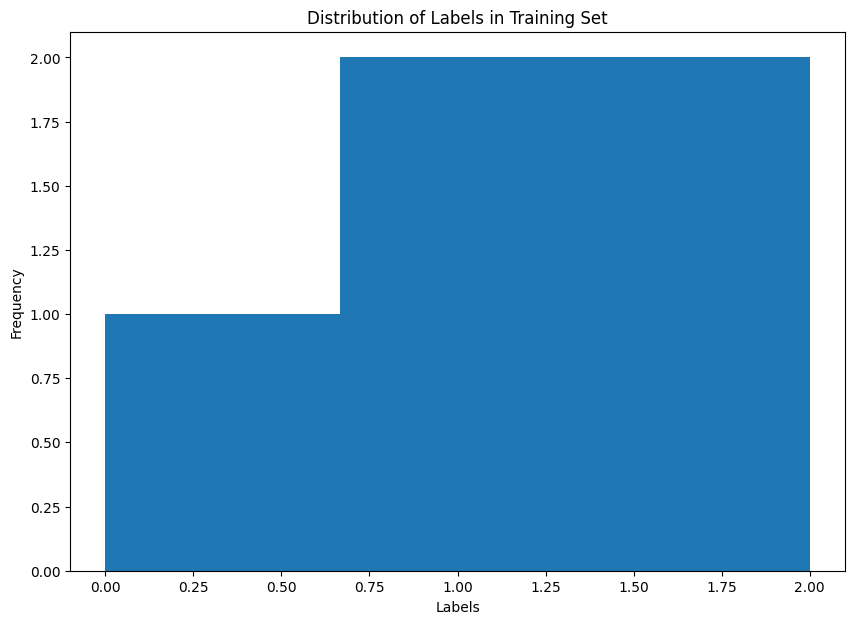

In [ ]:
# Plot the data
# Assuming 'X_train' contains text data and is not suitable for direct plotting
# Instead, we can plot the distribution of labels in the training set
plt.figure(figsize=(10, 7))
plt.hist(y_train, bins=len(set(y_train))) # Plot histogram of labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Set')
plt.show()

In [ ]:
# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:

# Example Usage
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = TextDataset(X_train, y_train, tokenizer, max_len=128)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = TreeClassifier(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

epochs = 100

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in data_loader:
        # Retrieve data from batch
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        # Forward pass: Get predictions from the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, num_classes]

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass: Optimize the model
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        total_loss += loss.item()

    # Logging the loss for this epoch
    avg_loss = total_loss / len(data_loader)

    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")



Epoch 1/100, Loss: 1.0509
Epoch 11/100, Loss: 0.6961
Epoch 21/100, Loss: 0.4192
Epoch 31/100, Loss: 0.3132
Epoch 41/100, Loss: 0.1567
Epoch 51/100, Loss: 0.0966
Epoch 61/100, Loss: 0.0542
Epoch 71/100, Loss: 0.0366
Epoch 81/100, Loss: 0.0298
Epoch 91/100, Loss: 0.0207


In [ ]:
test_dataset = TextDataset(X_test, y_test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model.eval()
# Store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, num_classes]
        predictions = torch.argmax(outputs, dim=1)  # Get predicted class (index of max logit)

        # Collect results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Compute Accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score)
#print("Classification Report:")
#print(classification_report(all_labels, all_predictions, target_names=label_names))


Test Accuracy: 1.0000


In [ ]:
def predict_single_text(model, tokenizer, text, max_len=128):
    model.eval()
    with torch.no_grad():
        # Tokenize input text
        encoding = tokenizer(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']

        # Get prediction
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_class = torch.argmax(output, dim=1).item()

    return predicted_class

# Example
text = "y jdchbkwkshf"
predicted_class = predict_single_text(model, tokenizer, text)
print(f"Predicted Class: {predicted_class}, label: {label_names[predicted_class]}")


Predicted Class: 0, label: y class
